## Normalizing flow demos. 
References:
* https://github.com/acids-ircam/pytorch_flows/blob/master/flows_01.ipynb
* https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
* https://blog.evjang.com/2018/01/nf1.html
* https://blog.evjang.com/2018/01/nf1.html


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torch.distributions.transforms as T
import torch.distributions as D
import torch.nn.functional as F

import torchvision.datasets as dset

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Define grids of points for plotting
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

#### Density and Transform

In [10]:
q0 = D.Normal(0, 1)
td_exp = T.ExpTransform()
q1 = D.TransformedDistribution(q0, td_exp)

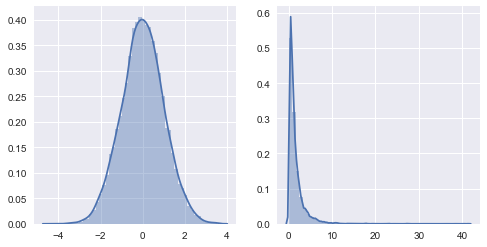

In [11]:
# sampled densities
q0_samples = q0.sample((int(1e4), ))
q1_samples = q1.sample((int(1e4), ))

plt.rcParams['figure.figsize'] = 8, 4
sns.set()
fig, axis = plt.subplots(nrows=1, ncols=2)    
sns.distplot(q0_samples, ax = axis[0])
sns.distplot(q1_samples, ax = axis[1])

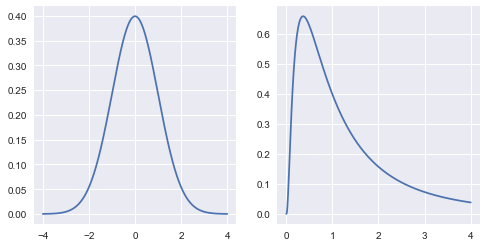

In [15]:
# True densities
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
q1_density = torch.exp(q1.log_prob(torch.Tensor(x))).numpy()

plt.rcParams['figure.figsize'] = 8, 4
sns.set()
fig, axis = plt.subplots(nrows=1, ncols=2)    
axis[0].plot(x, q0_density)
axis[1].plot(x, q1_density)

### Chaining transforms

In [16]:
q0 = D.MultivariateNormal(torch.ones(2), torch.eye(2))

# exp transform
f1 = T.ExpTransform()
q1 = D.TransformedDistribution(q0, f1)

# Affine transform
f2 = T.AffineTransform(2, torch.Tensor([0.2, 1.5]))

# Dist q2 as transform on q0 via f1, f2
q2 = D.TransformedDistribution(q0, [f1, f2])

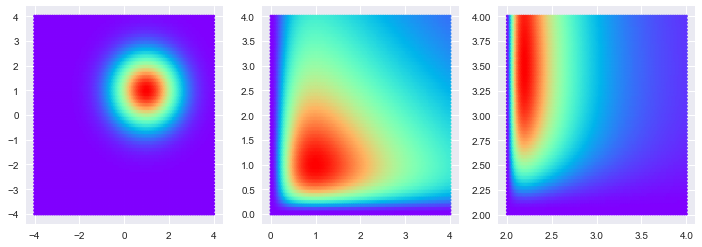

In [27]:
plt.rcParams['figure.figsize'] = 12, 4
fig, axis = plt.subplots(nrows=1, ncols=3)
axis[0].hexbin(z[:, 0], z[:, 1], torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
axis[1].hexbin(z[:, 0], z[:, 1], torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
axis[2].hexbin(z[:, 0], z[:, 1], torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
plt.show()

### Planar flow

In [2]:
class PlanarFlow(T.Transform):
    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__()
        self.bijective = False
        self.weight = weight
        self.scale = scale
        self.bias = bias
        

    # Transform classes should implement _call (forward) or _inverse()
    def _call(self, z):
        f_z = torch.mm(z, self.weight.t()) + self.bias
        return z + self.scale * torch.tanh(f_z)
    
    def log_abs_det_jacobian(self, z):
        f_z = torch.mm(z, self.weight.t()) + self.bias
        psi_z = (1 - torch.pow(torch.tanh(f_z), 2)) * self.weight
        det_grad = 1 + torch.mm(psi_z, self.scale.t())
        return torch.log(det_grad.abs() + 1e-7)

In [58]:
w = torch.Tensor([[3.0, 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])

q0 = D.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow_0 = PlanarFlow(w, u, b)
q1 = D.TransformedDistribution(q0, flow_0)

# Show emperical samples from q1, because the planar flow isn't invertible in all regions
# of space
q0_samples = q0.sample((int(1e6), ))
q1_samples = q1.sample((int(1e6), ))

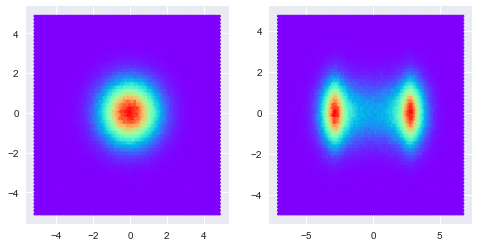

In [59]:
plt.rcParams['figure.figsize'] = 8, 4
fig, axis = plt.subplots(nrows=1, ncols=2)
axis[0].hexbin(q0_samples[:, 0], q0_samples[:, 1], cmap='rainbow')
axis[1].hexbin(q1_samples[:, 0], q1_samples[:, 1], cmap='rainbow')
plt.show()

In [60]:
# Change of variables / jacobian
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))

# Apply transform to coordinates
f_z = flow_0(torch.Tensor(z))

# Obtain the density
q1_density = q0_density.squeeze() / \
    np.exp(flow_0.log_abs_det_jacobian(torch.Tensor(z)).squeeze())
    

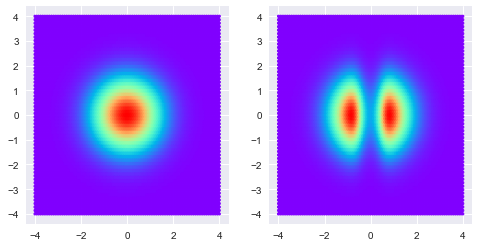

In [61]:
plt.rcParams['figure.figsize'] = 8, 4
fig, axis = plt.subplots(nrows=1, ncols=2)
axis[0].hexbin(z[:, 0], z[:, 1], q0_density, cmap='rainbow')
axis[1].hexbin(z[:, 0], z[:, 1], q1_density, cmap='rainbow')
plt.show()

### Optimizing normalizing flows

In [3]:
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()
    
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
    
    def forward(self, z):
        f_z = torch.mm(z, self.weight.t()) + self.bias
        return z + self.scale * torch.tanh(f_z)
    
    def log_abs_det_jacobian(self, z):
        f_z = torch.mm(z, self.weight.t()) + self.bias
        psi_z = (1 - torch.pow(torch.tanh(f_z), 2)) * self.weight
        det_grad = 1 + torch.mm(psi_z, self.scale.t())
        return torch.log(det_grad.abs() + 1e-7)

In [4]:
# For approximation, chain multiple planar flows in new modulule
class NormalizingFlow(nn.Module):
    def __init__(self, dim, n_flow):
        super().__init__()
        bijectors = []
        for flow in range(n_flow):
            bijectors.append(PlanarFlow(dim))
            
        self.bijectors = nn.ModuleList(bijectors)
        self.log_det = []
    
    def forward(self, z):
        self.log_det = []
        for bijector in self.bijectors:
            # save log abs jac
            self.log_det.append(bijector.log_abs_det_jacobian(z))
            # forward
            z = bijector(z)
        return z, self.log_det

In [76]:
# Complex density we wish to learn
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

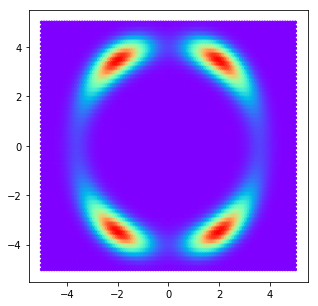

In [77]:
plt.rcParams['figure.figsize'] = 5, 5
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:, 0], z[:, 1], density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
_ = plt.show()

In [80]:
# loss
def flow_loss(target_dist_func, zk, log_abs_jac, beta):
    sum_of_log_jacobians = sum(log_abs_jac)
    beta = 1.0 if beta is None else beta
    return (- sum_of_log_jacobians - beta * torch.log(target_dist_func(zk) + 1e-9)).mean()

Loss (it. 0) : 18.032316, Beta: 0.010000
Loss (it. 1000) : 1.943397, Beta: 0.109990
Loss (it. 2000) : 0.875755, Beta: 0.209980
Loss (it. 3000) : 0.947570, Beta: 0.309970
Loss (it. 4000) : 0.643646, Beta: 0.409960
Loss (it. 5000) : 0.631091, Beta: 0.509950
Loss (it. 6000) : 0.715670, Beta: 0.609940
Loss (it. 7000) : 0.626462, Beta: 0.709930
Loss (it. 8000) : 0.591541, Beta: 0.809920
Loss (it. 9000) : 0.589220, Beta: 0.909910
Loss (it. 10000) : 0.581797, Beta: 1.000000


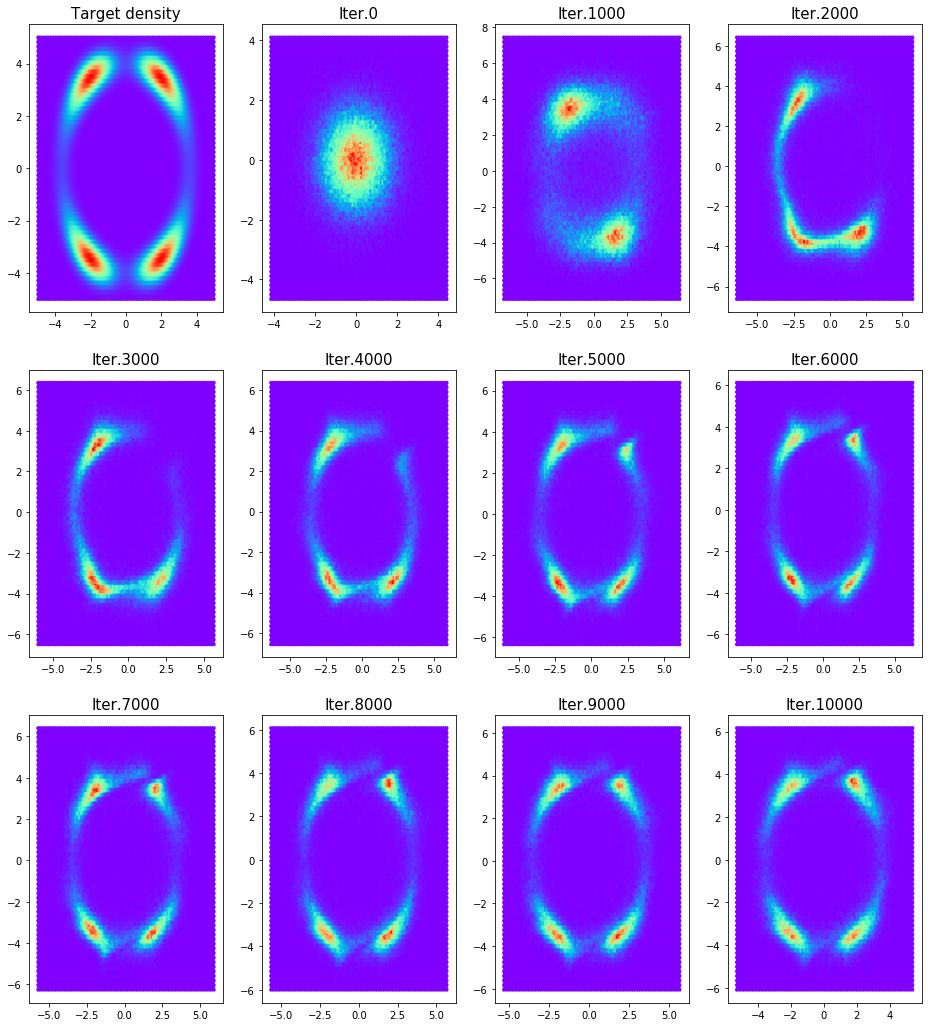

In [82]:
id_figure = 2

# visualization
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

plt.rcParams['figure.figsize'] = 16, 18
plt.figure(figsize=(16, 18))
plt.subplot(3, 4, 1)
plt.hexbin(z[:, 0], z[:, 1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);

n_epoch = 10000

# Begin distribution, Target distribution and training data
q0 = D.MultivariateNormal(torch.zeros(2), torch.eye(2))

# target distribution function
target_dist_func = density_ring

# Flow Model
flow_model = NormalizingFlow(dim=2, n_flow=16)
# Optimizer
optimizer = optim.Adam(flow_model.parameters(), lr=2e-3)
# Schedular
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

# main optimization loop
for i in range(0, n_epoch + 1):

    # annealing for loss, going from 0.01 to 1 over all epochs
    beta = min(1, 0.01 + float(i) / (float(n_epoch) + 1.) )

    # draw sample from reference normal multivariate
    samples = q0.sample((512, ))
    # Flow forward
    z, log_det = flow_model(samples)
    # zero grad
    optimizer.zero_grad()
    # loss
    loss_f = flow_loss(target_dist_func, z, log_det, 1.0)
    # backprop
    loss_f.backward()
    
    optimizer.step()
    scheduler.step()
    
    if i % 1000 == 0:
        print('Loss (it. %i) : %f, Beta: %f' % (i, loss_f.item(), beta))
        samples = q0.sample((int(1e5), ))
        # Eval flow and plot
        z, _ = flow_model(samples)
        z = z.detach().numpy()
        plt.subplot(3, 4, id_figure)
        plt.hexbin(z[:, 0], z[:, 1], cmap='rainbow')
        plt.title('Iter.%i'%(i), fontsize=15);
        id_figure += 1
        